# Discrete PI with ITAE parameters
This notebook reproduces Figure 17.10 in Seborg et al.

In [1]:
import sys
sys.path.append('../../lib/')
import blocksim
import fopdtitae

In [2]:
import numpy
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class DiscretePI(blocksim.Block):
    def __init__(self, name, inputname, outputname, K, tau_I, deltat):
        super().__init__(name, inputname, outputname)

        self.K = K
        self.tau_I = tau_I
        self.deltat = deltat
        self.reset()

    def reset(self):
        self.state = 0
        self.output = 0
        self.eint = 0
        self.nextsample = 0
        
    def change_input(self, t, e):
        if t >= self.nextsample:
            self.eint += e*self.deltat
            self.output = self.K*(e + self.eint/self.tau_I)
            self.nextsample += self.deltat
            
        return self.output
    
    def change_state(self, x):
        self.state = x
        
    def derivative(self, e):
        return 0

In [4]:
class DiscretePI_vel(DiscretePI):
    def reset(self):
        self.state = 0
        self.output = 0
        self.e_k_1 = 0
        self.nextsample = 0
        
    def change_input(self, t, e_k):
        if t >= self.nextsample:
            self.output += self.K*((e_k - self.e_k_1) + self.deltat/self.tau_I*e_k) 
            
            self.e_k_1 = e_k
            self.nextsample += self.deltat

        return self.output

The system is

$$ G = G_v G_p G_m = \frac{-20 e^{-s}}{5s + 1} = \frac{K_p e^{-\theta s}}{\tau_p s + 1}$$

It is not explicitly stated in the example, but $G_d = G$ is assumed.

In [13]:
Kp = -20
taup = 5
theta = 1

In [14]:
G = blocksim.LTI('G', 'u', 'yu',
                 Kp, [taup, 1], theta)

In [15]:
Gd = blocksim.LTI('G', 'd', 'yd',
                  Kp, [taup, 1], theta)

Note we can't just do `G = Gd` because we need new names and a new state for the block.

In [16]:
sums = {'y': ('+yu', '+yd'),
        'e': ('-y', '+r')}

In [9]:
inputs = {'r': lambda t: 0,
          'd': lambda t: 1}

In [10]:
ts = numpy.linspace(0, 15, 2000)

In [11]:
deltats = [0.05, 0.25, 0.5, 1]

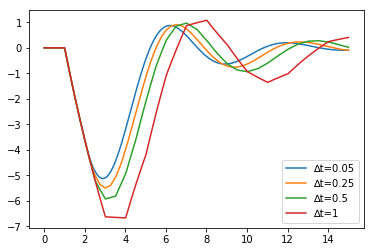

In [12]:
for deltat in deltats:
    Kc, tau_I = fopdtitae.parameters(Kp, taup, theta + deltat/2)
    Gc = DiscretePI('Gc', 'e', 'u',
                    Kc, tau_I, deltat)
    diagram = blocksim.Diagram([G, Gd, Gc], sums, inputs)
    outputs = diagram.simulate(ts)
    plt.plot(ts, outputs['y'], label='∆t={}'.format(deltat))
plt.legend()